<a href="https://colab.research.google.com/github/gilsonauerswald/Bioinformatic_Projects/blob/main/Sequence_to_Structure_%E2%80%93_Protein_Structure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 6: Sequence to Structure – Protein Structure Prediction
# OmicsLogic Molecular Modeling Tutorial

 Copyright (c) 2025 OmicsLogic
 This notebook is part of the OmicsLogic Molecular Modeling Tutorial series.

 This notebook requires a Google Colab environment to run properly.
 To use this notebook:
 1. Copy all content into a new Google Colab notebook
 2. Run each cell sequentially
 3. Follow along with the explanations and instructions


## Introduction

Protein structure prediction is a fundamental challenge in computational biology and a crucial step in molecular modeling workflows. In this lesson, we'll explore how to predict three-dimensional protein structures from amino acid sequences using **AI-based methods (AlphaFold/ColabFold).**

This notebook provides an extremely simplified approach to protein structure prediction and visualization that avoids virtually all dependency issues in Google Colab.

It focuses on:
1. Using pre-computed structures from PDB and AlphaFold DB
2. Basic visualization and analysis

## Part 1: Setup and environment check

In [ ]:
# Setup and environment check
!pip install biopython  # Install the Biopython library
import os
import sys
import urllib.request
import matplotlib.pyplot as plt
import time

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules
if not IN_COLAB:
    print("⚠️ This notebook is designed to run in Google Colab.")
else:
    print("✅ Running in Google Colab environment")

# Create directory for structures
os.makedirs("structures", exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.7 MB/s eta 0:00:00
✅ Running in Google Colab environment


## Part 1: Accessing Protein Structures
Instead of predicting structures directly (which requires complex dependencies), we'll download pre-computed structures.

In [ ]:
# Minimal function to download files from the web
def download_file(url, output_path, max_retries=3):
    """Download a file from URL with retries"""
    for attempt in range(max_retries):
        try:
            print(f"Downloading from {url}...")
            urllib.request.urlretrieve(url, output_path)
            print(f"Successfully downloaded to {output_path}")
            return output_path
        except Exception as e:
            print(f"Download attempt {attempt+1} failed: {e}")
            if attempt + 1 < max_retries:
                wait_time = 2 ** attempt  # Exponential backoff
                print(f"Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print("All download attempts failed")
                return None


### Option 1: Download from AlphaFold Protein Structure Database

In [ ]:
# Function to download from AlphaFold DB
def get_alphafold_structure(uniprot_id):
    """Download a structure from AlphaFold Database"""
    output_file = f"structures/AF-{uniprot_id}.pdb"
    url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"
    return download_file(url, output_file)

# Let's try to get CDK2 structure

cdk2_pdb = get_alphafold_structure("P24941")  # CDK2 UniProt ID

Successfully downloaded to structures/AF-P24941.pdb


### Option 2: Download from PDB (Experimental Structures)

In [ ]:
# Function to download from PDB
def get_pdb_structure(pdb_id):
    """Download a structure from PDB"""
    pdb_id = pdb_id.lower()  # PDB IDs are typically lowercase
    output_file = f"structures/{pdb_id}.pdb"
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    return download_file(url, output_file)

# Get a CDK2 experimental structure
cdk2_exp_pdb = get_pdb_structure("1HCK")  # A well-known CDK2 structure

Successfully downloaded to structures/1hck.pdb


### Option 3: Using the Official ColabFold Notebook

For proteins not in the AlphaFold DB or when you need more control over the prediction, use the official ColabFold notebook:

1. Open the notebook: [ColabFold Notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)
2. Enter your protein sequence
3. Run the prediction
4. Download the resulting PDB file
5. Upload it to this notebook for further analysis

Below, we'll assume you've done this and have a structure file available.


## Part 2: Basic Visualization

We'll use matplotlib for basic structure visualization, which is always available in Colab.

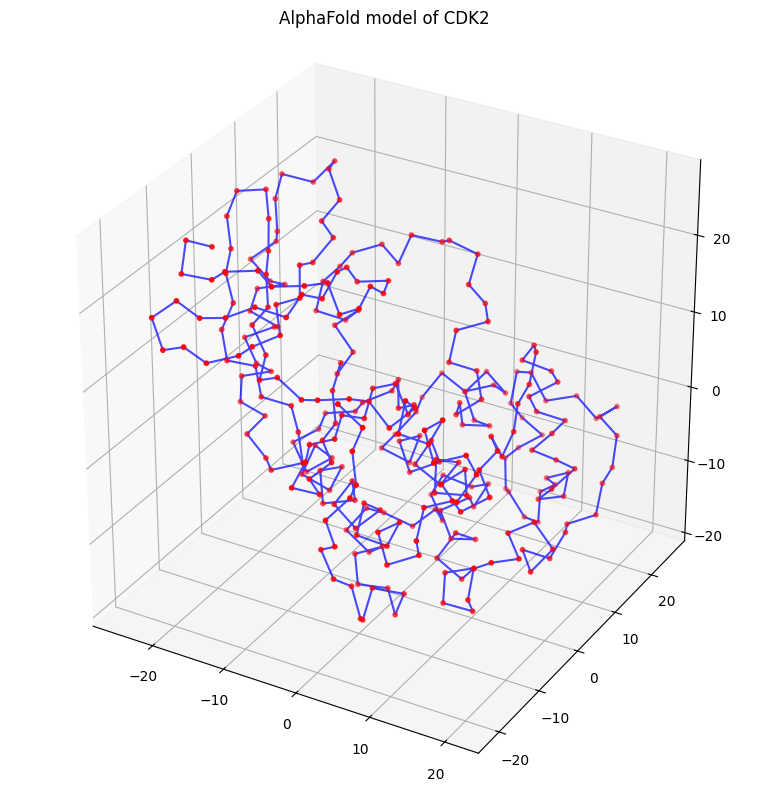

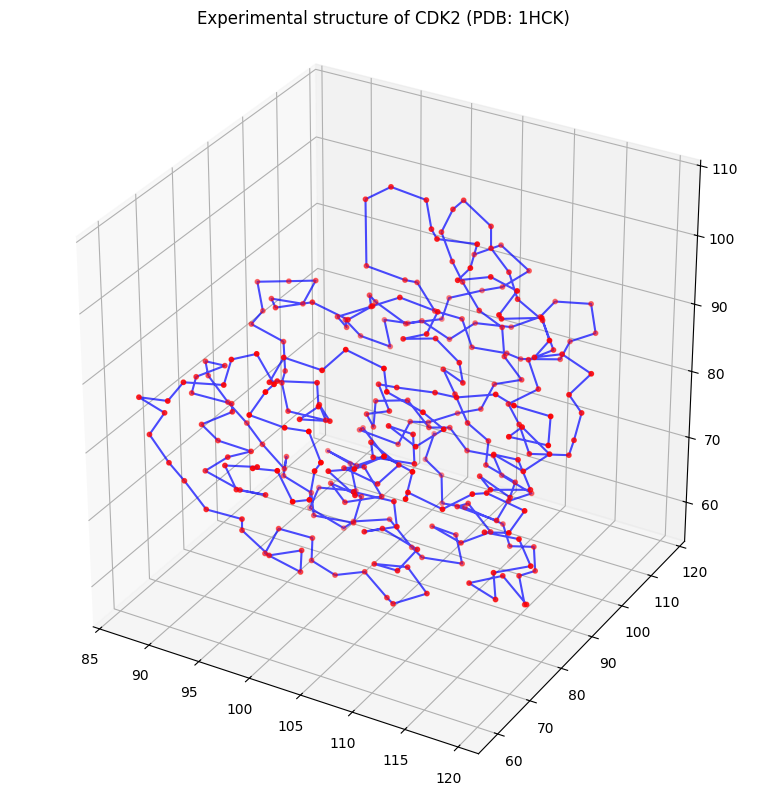

In [ ]:
# Basic function to visualize protein backbone from PDB
def plot_backbone(pdb_file, title=None):
    """Plot protein backbone in 3D using matplotlib"""
    if not pdb_file or not os.path.exists(pdb_file):
        print(f"Cannot visualize: {pdb_file} not found")
        return

    # Extract CA atoms from PDB file
    ca_coords = []
    with open(pdb_file, 'r') as f:
        for line in f:
            if line.startswith("ATOM") and "CA" in line[12:16]:
                # Extract x, y, z coordinates
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                ca_coords.append((x, y, z))

    if not ca_coords:
        print("No CA atoms found in the PDB file")
        return

    # Convert to numpy arrays for plotting
    import numpy as np
    coords = np.array(ca_coords)

    # Create 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the backbone trace
    ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], '-', color='blue', alpha=0.7)

    # Add points for each CA atom
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], color='red', s=10)

    # Set title
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"Backbone trace: {os.path.basename(pdb_file)}")

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()

    return fig, ax

    # Visualize AlphaFold structure
if cdk2_pdb:
    plot_backbone(cdk2_pdb, "AlphaFold model of CDK2")
else:
    print("No AlphaFold structure available to visualize")

# %%
# Visualize experimental structure
if cdk2_exp_pdb:
    plot_backbone(cdk2_exp_pdb, "Experimental structure of CDK2 (PDB: 1HCK)")
else:
    print("No experimental structure available to visualize")

## Part 3: Simple PDB Analysis

We'll now perform some simple analyses on the PDB files:


In [ ]:
# Function to extract basic statistics from PDB
def analyze_pdb(pdb_file):
    """Extract basic information from a PDB file"""
    if not os.path.exists(pdb_file):
        print(f"Cannot analyze: {pdb_file} not found")
        return

    # Initialize counters
    atom_count = 0
    residue_types = set()
    chains = set()
    residues = set()

    # Track the current residue
    current_res = None

    with open(pdb_file, 'r') as f:
        for line in f:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                atom_count += 1

                # Extract chain ID
                chain_id = line[21]
                chains.add(chain_id)

                # Extract residue name
                res_name = line[17:20].strip()
                residue_types.add(res_name)

                # Extract residue number and insertion code
                res_num = line[22:26].strip()
                ins_code = line[26].strip()
                res_id = (chain_id, res_name, res_num, ins_code)

                if res_id != current_res:
                    current_res = res_id
                    residues.add(res_id)

    # Print statistics
    print(f"PDB File: {os.path.basename(pdb_file)}")
    print(f"Total atoms: {atom_count}")
    print(f"Total residues: {len(residues)}")
    print(f"Chains: {', '.join(sorted(chains))}")
    print(f"Residue types: {', '.join(sorted(residue_types))}")
    print("---")

    return {
        "atom_count": atom_count,
        "residue_count": len(residues),
        "chains": chains,
        "residue_types": residue_types
    }

# Now let's analyze our structures:

# Analyze AlphaFold structure
if cdk2_pdb:
    af_stats = analyze_pdb(cdk2_pdb)
else:
    print("No AlphaFold structure available to analyze")

# %%
# Analyze experimental structure
if cdk2_exp_pdb:
    exp_stats = analyze_pdb(cdk2_exp_pdb)
else:
    print("No experimental structure available to analyze")

PDB File: AF-P24941.pdb
Total atoms: 2398
Total residues: 298
Chains: A
Residue types: ALA, ARG, ASN, ASP, CYS, GLN, GLU, GLY, HIS, ILE, LEU, LYS, MET, PHE, PRO, SER, THR, TRP, TYR, VAL
---
PDB File: 1hck.pdb
Total atoms: 2510
Total residues: 404
Chains: A
Residue types: ALA, ARG, ASN, ASP, ATP, CYS, GLN, GLU, GLY, HIS, HOH, ILE, LEU, LYS, MET, MG, PHE, PRO, SER, THR, TRP, TYR, VAL
---


## Part 4: Basic Structure Comparison

Let's compare the AlphaFold and experimental structures:

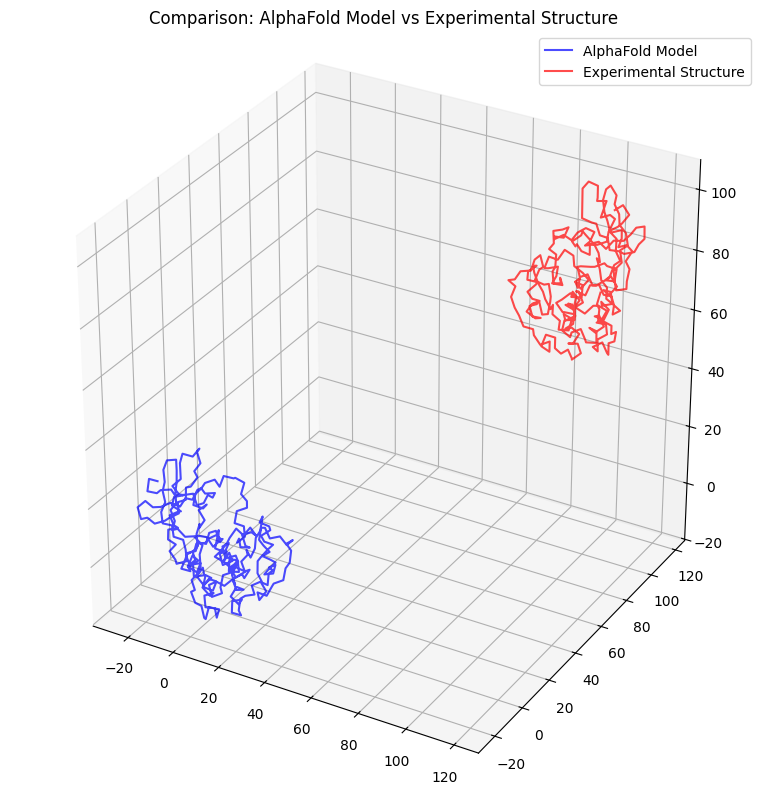

In [ ]:
# Function to compare structures based on backbone trace
def compare_backbones(pdb1, pdb2, labels=("Structure 1", "Structure 2")):
    """Compare backbone traces of two structures"""
    if not os.path.exists(pdb1) or not os.path.exists(pdb2):
        print("Cannot compare: one or both PDB files not found")
        return

    # Extract CA atoms from both PDBs
    coords1 = []
    coords2 = []

    with open(pdb1, 'r') as f:
        for line in f:
            if line.startswith("ATOM") and "CA" in line[12:16]:
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                coords1.append((x, y, z))

    with open(pdb2, 'r') as f:
        for line in f:
            if line.startswith("ATOM") and "CA" in line[12:16]:
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                coords2.append((x, y, z))

    import numpy as np
    coords1 = np.array(coords1)
    coords2 = np.array(coords2)

    # Create 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot both backbone traces
    ax.plot(coords1[:, 0], coords1[:, 1], coords1[:, 2], '-', color='blue', alpha=0.7, label=labels[0])
    ax.plot(coords2[:, 0], coords2[:, 1], coords2[:, 2], '-', color='red', alpha=0.7, label=labels[1])

    # Add legend
    ax.legend()

    # Set title
    ax.set_title(f"Comparison: {labels[0]} vs {labels[1]}")

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()

    # Note: A proper comparison would align the structures first,
    # but this requires more complex dependencies. This is just a basic visualization.

    return fig, ax

# %%
# Compare AlphaFold and experimental structures
if cdk2_pdb and cdk2_exp_pdb:
    compare_backbones(
        cdk2_pdb,
        cdk2_exp_pdb,
        labels=("AlphaFold Model", "Experimental Structure")
    )
else:
    print("Cannot compare structures - need both AlphaFold and experimental structures")

## Summary and Conclusions

In this tutorial, we've explored a minimal approach to protein structure visualization and analysis that works reliably in Google Colab without complex dependencies:

1. **Downloading pre-computed structures** from AlphaFold DB and PDB
2. **Basic visualization** using matplotlib
3. **Simple structure analysis** by parsing PDB files
4. **Visual comparison** of different structures

While this approach doesn't allow direct structure prediction with ColabFold or MODELLER, it provides a foundation for understanding protein structures and can be extended with more advanced tools when needed.